In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/export/bbq2/dfm/anaconda3/lib/python3.4/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [58]:
campaign = 1
epicid = "201554363"

# epicid = "201367065"
# epicid = "201912552"
# epicid = "201754305"

# campaign = 3
# epicid = "206475757"

# campaign = 4
# epicid = "211056809"
# epicid = "211028585"

basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    detrend=False,
    invert=True,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    # initial_time=2179.0,
    # initial_time=2264.0,
    skip=0,
    durations=[0.1],
    min_period=1.0,
    max_period=50.,
    npeaks=2,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [59]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [60]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 1.04s
Querying Likelihood
tau = 8.679229736328125
tau = 8.679229736328125
tau = 8.302093505859375
tau = 4.17938232421875
tau = 4.17938232421875
tau = 4.1844482421875
Finished querying Likelihood in 6.29s
Querying OneDSearch
Finished querying OneDSearch in 12.70s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 10.92s
Querying Vetter
Finished querying Vetter in 3.26s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


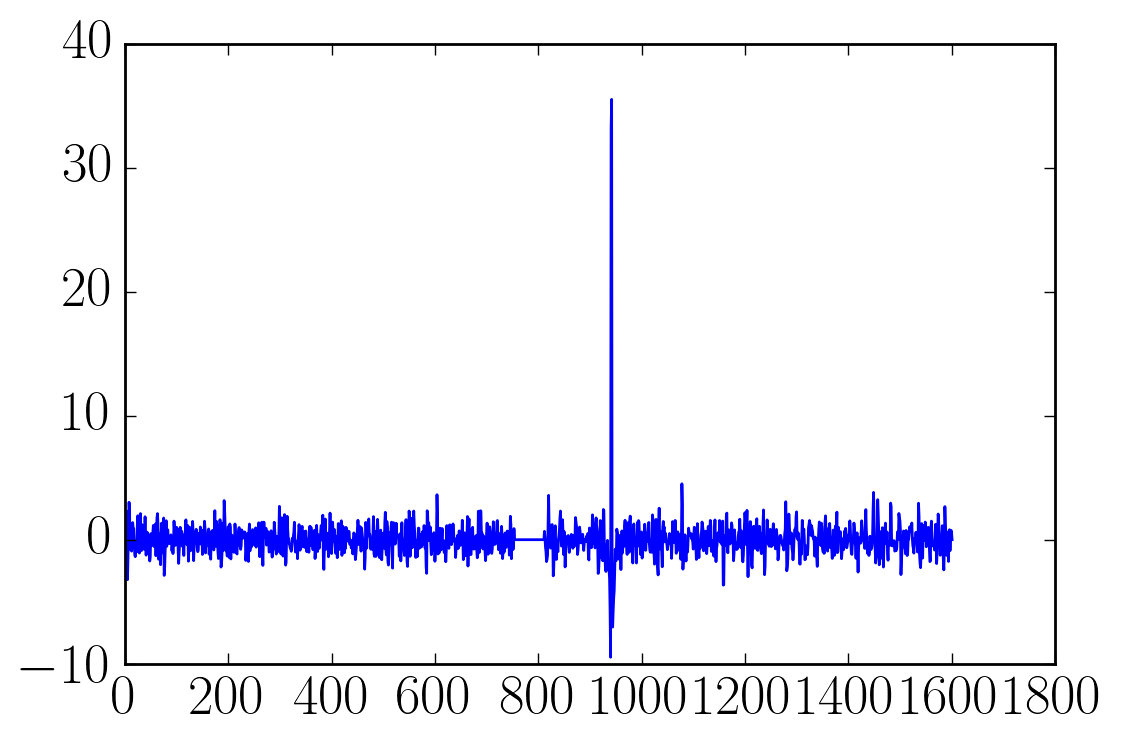

In [61]:
pl.plot(r.depth_1d * np.sqrt(r.depth_ivar_1d))

In [62]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.detrend_flux, ".") for lc in lcs];

AttributeError: 'K2LightCurve' object has no attribute 'detrend_flux'

In [63]:
r.peaks

[{'depth': 25.270069677326408,
  'depth_ivar': 1.9501499736705552,
  'duration': 0.1,
  'lnZ_box': -2782.1124027877231,
  'lnZ_none': -3481.9748232568991,
  'lnZ_outlier': -2619.4891730106901,
  'lnZ_transit': -1957.6616078462707,
  'lnZ_vee': -2306.0123036274858,
  'lnlike_box': -2782.781102774682,
  'lnlike_none': -3481.9748232568991,
  'lnlike_outlier': -2622.1147892849785,
  'lnlike_transit': -1931.7055780280284,
  'lnlike_vee': -2307.1729264697542,
  'period': 47.076343672381874,
  'phic_same': -1250.8412545064884,
  'phic_same_second': -1864.3843995555735,
  'phic_variable': -3109.9375499934272,
  's2n': 35.28908884582993,
  't0': 9.3390389848818742,
  'transit_b': -0.14251777648495817,
  'transit_duration': 0.062366546852692169,
  'transit_period': 47.044383666615126,
  'transit_q1': 0.4716332338222588,
  'transit_q2': 0.48765310647284399,
  'transit_ror': 0.22429872274848073,
  'transit_t0': 9.327658763648996},
 {'depth': 2.686702063793931,
  'depth_ivar': 5.0893585009347611,
 

(8.327658763648996, 10.327658763648996)

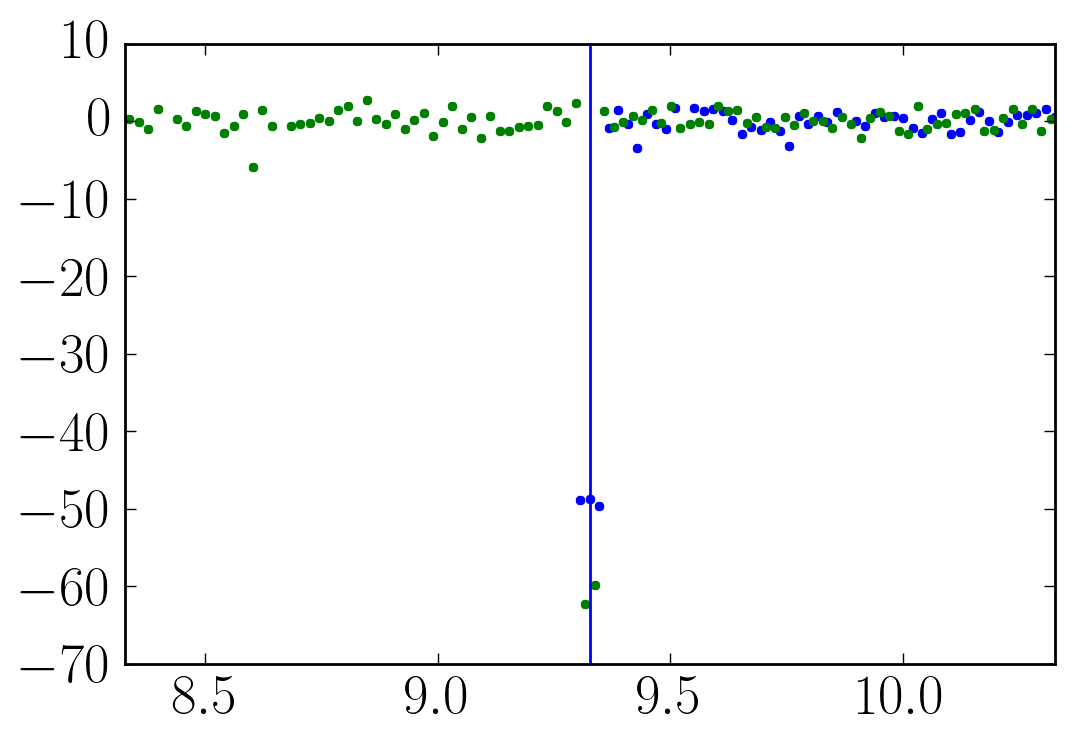

In [65]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
# [pl.plot(lc.time %  p["transit_period"], m, ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)